# Grounding dino 모델 사용
- 참고 문서
    - https://github.com/autodistill/autodistill/blob/main/docs/base_models/grounding-dino.md
    - https://github.com/IDEA-Research/GroundingDINO/tree/main

In [ ]:
# 사전 설치
# !pip install autodistill-grounding-dino

### 폴더 생성 그 후 1차 검증한 영상 videos 폴더에 넣기

In [4]:
# 폴더 생성
import os

if os.path.exists('./videos') == False and os.path.exists('./images') == False:
    os.mkdir('./videos')
    os.mkdir('./images')
    print('폴더 생성 완')
else:
    print('폴더 존재')
    pass

폴더 생성 완


In [5]:
# videos에 파일 개수 확인
file_count = os.listdir('./videos/')
len(file_count)

16

In [5]:
# 경로 지정
VIDEO_DIR_PATH = "./videos"
IMAGE_DIR_PATH = "./images"
FRAME_STRIDE = 60

### videos 폴더 있는 동영상 10프레임별로 이미지 나누기 10프레임은 위에 셀에서 지정.

In [10]:
# 동영상 읽고 이미지로 생성
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    # 동영상 파일의 확장자 지정하는 곳
    extensions=["avi", "mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/14 [00:00<?, ?it/s]

In [9]:
# 이미지 전체 개수 파악
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 2507


### 내 pc에서 gpu 자원 사용 가능한지 파악

In [ ]:
import torch

# GPU 사용 여부 확인
if torch.cuda.is_available():
    print("GPU 사용 가능")
else:
    print("GPU 사용 불가능")

In [ ]:
import tensorflow as tf

# GPU 사용 여부 확인
if tf.config.list_physical_devices("GPU"):
    print("GPU 사용 가능")
else:
    print("GPU 사용 불가능")

### 오토 라벨링 전 클래스 지정

In [13]:
# 오토 라벨링 작업전 클래스 지정
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "person": "person",
    "bicycle": "bicycle",
    'car' : 'car',
    'motorcycle' : 'motorcycle',
    'bus' : 'bus',
    'truck' : 'truck'
})


### Grounding-dino 모델 사용해서 라벨링 진행!

In [15]:
# 오토 라벨링 진행
base_model = GroundingDINO(ontology=ontology)

base_model.label(
    input_folder = "./images/",
    extension=".png",
    output_folder ='./dataset')

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling ./images\20180101_155236_INF_2-00000.png:   0%|          | 0/2507 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
None of the inputs have requires_grad=True. Gradients will be None
Labeling ./images\20180102_122049_INF_2-00177.png: 100%|██████████| 2507/2507 [5:13:33<00:00,  7.50s/it]  


PermissionError: [WinError 5] 액세스가 거부되었습니다: './dataset\\images\\20180102_121949_INF_2-00028.png'

### supvervision 사용하여 객체 탐지

In [1]:
# 위 학습 종료 후 dataset 폴더에서 라벨데이터랑, 이미지데이터, data.yaml 경로 지정
ANNOTATIONS_DIRECTORY_PATH = "./dataset/annotations/"
IMAGES_DIRECTORY_PATH = "./dataset/images/"
DATA_YAML_PATH = "./dataset/data.yaml"

In [2]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

2180

In [26]:
IMAGE_DIR_PATH = "./images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

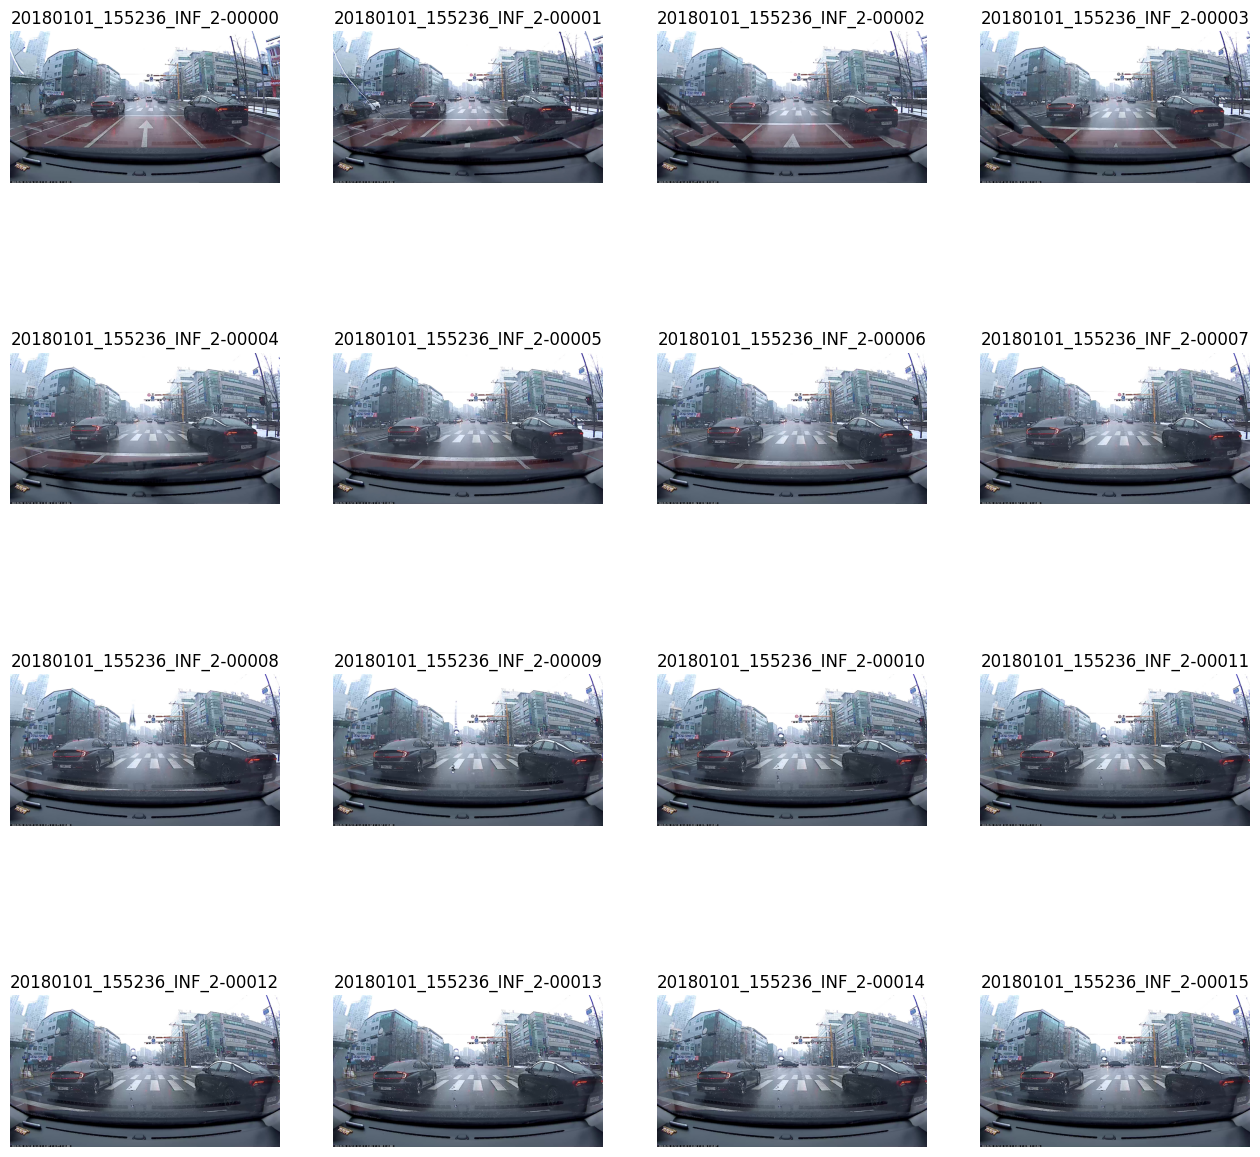

In [27]:
# 이미지 상태 확인
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

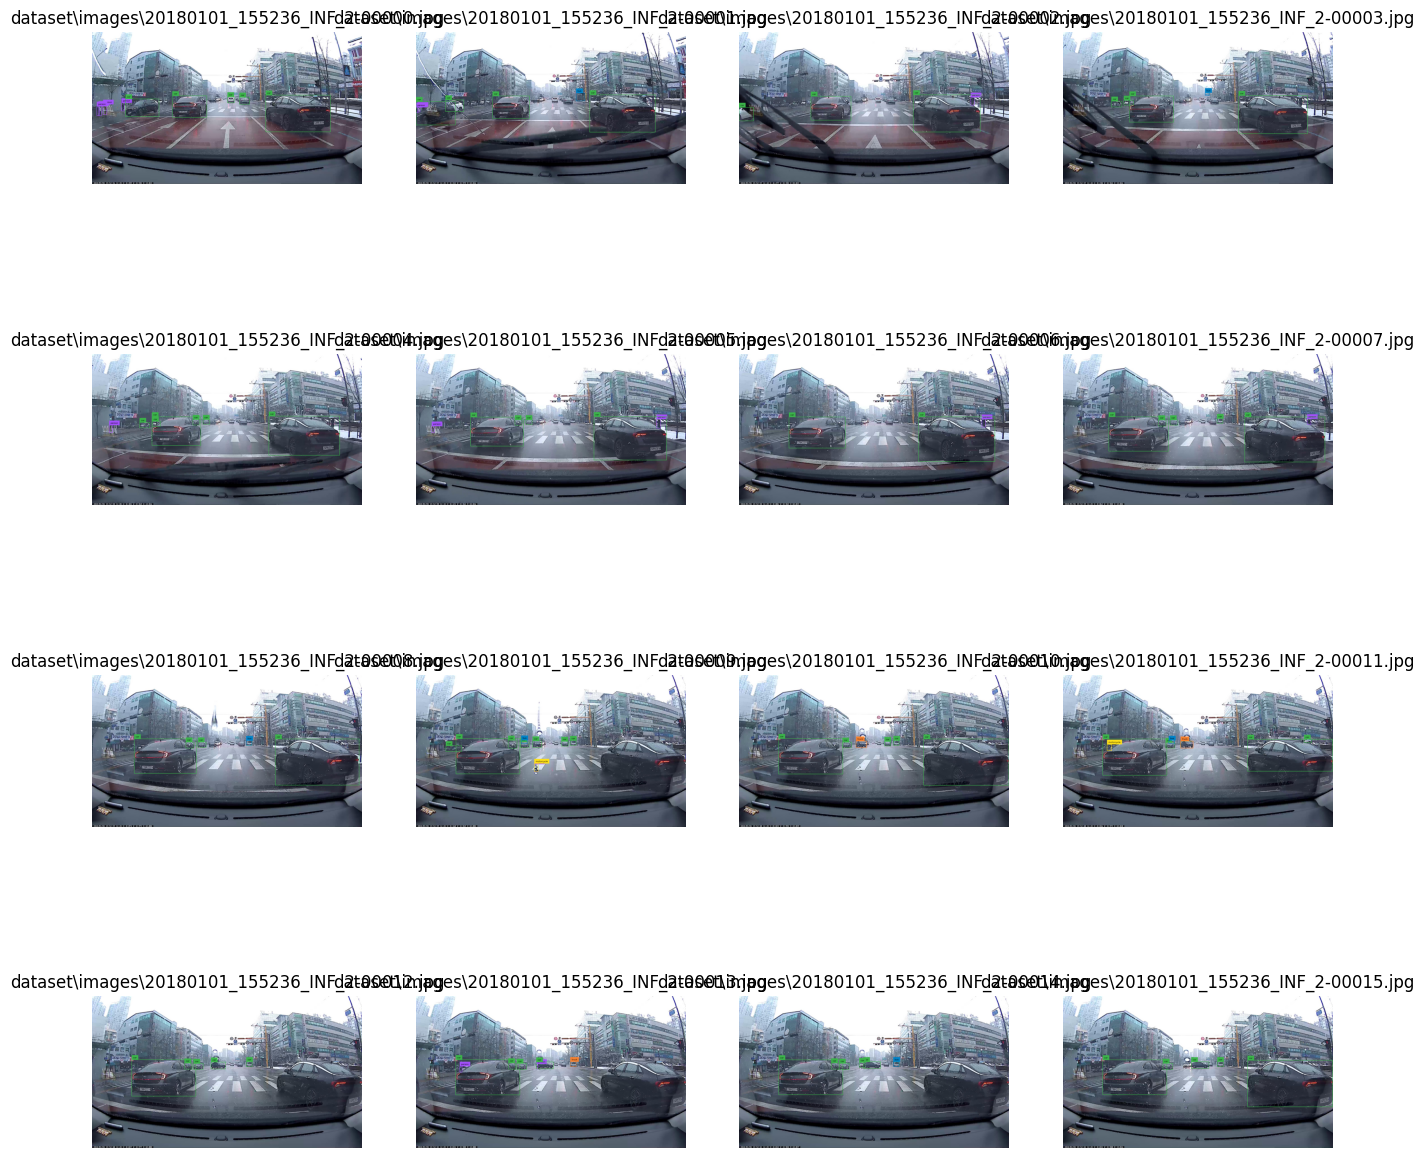

In [28]:
# txt파일에서 클래스, 박스좌표 이용해서 영상에 시각화
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

위 작업 결과를 통해서 opencv를 통해서 나머지 이미지 라벨링 잘 되어있는지 시각화<br><br>
1. 라벨링 잘 되어있는건 keep,<br>
2. 이미지 내 객체는 있지만 라벨링 잘 안되어있는 경우는 직접 라벨링 작업 및 txt 파일 수정<br>
3. 이미지 내 객체는 없지만 라벨링 되어있는 경우는 txt 파일, 이미지 삭제 or txt파일 삭제